In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
import torch


device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

Using device: cuda


In [ ]:

!cp -r /content/drive/MyDrive/Thesis/FSD50K /content/



KeyboardInterrupt: 

In [ ]:
!rsync -av --progress /content/drive/MyDrive/Thesis/FSD50K /content/

Streaming output truncated to the last 5000 lines.
        477,796 100%  796.24kB/s    0:00:00 (xfr#161, ir-chk=48854/51216)
FSD50K/FSD50K.dev_audio/122089.wav
      2,421,794 100%    2.62MB/s    0:00:00 (xfr#162, ir-chk=48853/51216)
FSD50K/FSD50K.dev_audio/122091.wav
      2,169,100 100%    1.53MB/s    0:00:01 (xfr#163, ir-chk=48852/51216)
FSD50K/FSD50K.dev_audio/122204.wav
         83,522 100%  159.31kB/s    0:00:00 (xfr#164, ir-chk=48851/51216)
FSD50K/FSD50K.dev_audio/122261.wav
        282,644 100%  354.33kB/s    0:00:00 (xfr#165, ir-chk=48850/51216)
FSD50K/FSD50K.dev_audio/122266.wav
         52,448 100%   51.79kB/s    0:00:00 (xfr#166, ir-chk=48849/51216)
FSD50K/FSD50K.dev_audio/122267.wav
         56,128 100%   43.68kB/s    0:00:01 (xfr#167, ir-chk=48848/51216)
FSD50K/FSD50K.dev_audio/122270.wav
         40,862 100%  188.23kB/s    0:00:00 (xfr#168, ir-chk=48847/51216)
FSD50K/FSD50K.dev_audio/122272.wav
         39,744 100%   91.32kB/s    0:00:00 (xfr#169, ir-chk=48846/51216)
FSD

In [ ]:
train_csv_path = '/content/FSD50K/FSD50K.metadata/collection/modified_collection_dev.csv' #kkkkxxtttvvvvvjjjgggnnnnfffssss
test_csv_path = '/content/FSD50K/FSD50K.metadata/collection/modified_collection_test.csv'
train_audio_dir = '/content/FSD50K/FSD50K.dev_audio/'
test_audio_dir = '/content/FSD50K/FSD50K.eval_audio/'

In [ ]:
import pandas as pd
import torchaudio
from torch.utils.data import Dataset, DataLoader
import os
import torch
import torch.nn as nn
import torch.nn.functional as F
import torchaudio.transforms as transforms
import torch.optim as optim
from sklearn.cluster import KMeans

In [ ]:
#train_csv_path = '/content/drive/MyDrive/Thesis/FSD50K/FSD50K.metadata/collection/modified_collection_dev.csv' #JJJJJJJJjjjggggbbbbhhhhhhgggjjjjjjjhhhhgggdddhhOOGA BOOGAAAAnnn
#test_csv_path = '/content/drive/MyDrive/Thesis/FSD50K/FSD50K.metadata/collection/modified_collection_test.csv' #jjjjjvvvvvnnnjjjjbbbbbbnnnnbbbnnnkkknnnnbbbbnnnnjjj WHEN CAPTAIN AMERICA THROWS HIS MIGHTY SHIELLLLLLLLLLLLLLLLLLLLLLLLLLLLLLLLLLLLLLDDDDDDDDDDDDDDDDDDD

train_df = pd.read_csv(train_csv_path)
test_df = pd.read_csv(test_csv_path)

train_df_sampled = train_df.sample(n=20483, random_state=42)

# Save the new CSV file with the reduced training dataset
train_csv_sampled_path = '/content/FSD50K/FSD50K.metadata/collection/modified_collection_dev_20483_new.csv'
train_df_sampled.to_csv(train_csv_sampled_path, index=False)

#train_csv_sampled_path = '/content/drive/MyDrive/Thesis/FSD50K/FSD50K.metadata/collection/modified_collection_dev_20483_new.csv'
#train_df_sampled.to_csv(train_csv_sampled_path, index=False)

print(f"Reduced CSV file saved to: {train_csv_sampled_path}")

test_df_sampled = test_df.sample(n=5116, random_state=42)  # Adjust 'n' as needed

# Save the new CSV file with the reduced test dataset
test_csv_sampled_path = '/content/FSD50K/FSD50K.metadata/collection/modified_collection_test_5116_new.csv'
test_df_sampled.to_csv(test_csv_sampled_path, index=False)

print(f"Reduced test CSV file saved to: {test_csv_sampled_path}")

# Update the DataFrame to be used in further processing
train_df = train_df_sampled

# Update the test DataFrame to be used in further processing
test_df = test_df_sampled

print(train_df['single_label'].dtype)
print(train_df['single_label'].unique())

train_df['single_label'] = train_df['single_label'].astype(str)
test_df['single_label'] = test_df['single_label'].astype(str)

# Now, continue with the rest of your code
unique_labels = sorted(train_df['single_label'].unique())
label_to_index = {label: idx for idx, label in enumerate(unique_labels)}
print(f"New label mapping: {label_to_index}")

# Apply the mapping
train_df['label_idx'] = train_df['single_label'].map(label_to_index)
test_df['label_idx'] = test_df['single_label'].map(label_to_index)

# Verify that the label indices are within the correct range
print(train_df['label_idx'].value_counts())  # Check the distribution of label indices
print(train_df['label_idx'].max())  # Ensure that the maximum index does not exceed num_classes - 1

# Convert filenames to strings if necessary
train_df['fname'] = train_df['fname'].astype(str)
test_df['fname'] = test_df['fname'].astype(str)

Reduced CSV file saved to: /content/FSD50K/FSD50K.metadata/collection/modified_collection_dev_20483_new.csv
Reduced test CSV file saved to: /content/FSD50K/FSD50K.metadata/collection/modified_collection_test_5116_new.csv
object
['Clarinet' 'Knock' 'Thunder' 'Burping_and_eructation'
 'Keyboard_(musical)' 'Hammer' 'Typing' 'Slam' 'Double_bass' 'Ukulele'
 'Shatter' 'Snare_drum' 'Cat' 'Alarm' 'Soprano_saxophone' 'Squeak'
 'Motorcycle' 'Idling' 'Cutlery_and_silverware' 'Dishes_and_pots_and_pans'
 'Rattle_(instrument)' 'Telephone' 'Gong' 'Saxophone' 'Frog' 'Cowbell'
 'Electric_guitar' 'Speech_synthesizer' 'Mallet_percussion' 'Aircraft'
 'Choir' 'French_horn' 'Sink_(filling_or_washing)' 'Battle_cry' 'Bicycle'
 'Subway_and_metro_and_underground' 'Violin_and_fiddle' 'Chink_and_clink'
 'Screaming' 'Drawer_open_or_close' 'Water_tap_and_faucet'
 'Male_speech_and_man_speaking' 'Toothbrush' 'Zipper_(clothing)'
 'Light_engine_(high_frequency)' 'Boat_and_Water_vehicle' 'Vibraphone'
 'Harp' 'Shout' 'Wa

In [ ]:
train_audio_dir = '/content/drive/MyDrive/Thesis/FSD50K/FSD50K.dev_audio/'
test_audio_dir = '/content/drive/MyDrive/Thesis/FSD50K/FSD50K.eval_audio/'

In [ ]:
from imblearn.over_sampling import RandomOverSampler

class FSD50KDataset(Dataset):
    def __init__(self, csv_file, audio_dir, transform=None, max_len=1000):
        self.dataframe = pd.read_csv(csv_file)
        self.audio_dir = audio_dir
        self.transform = transform
        self.max_len = max_len  # Maximum length to pad/truncate sequences
        self.mel_spectrogram = transforms.MelSpectrogram(
            sample_rate=16000,
            n_mels=64,
            n_fft=1024,
            hop_length=512
        )


        self.dataframe = self.dataframe.dropna(subset=['single_label'])


        self.label_to_idx = {label: idx for idx, label in enumerate(self.dataframe['single_label'].unique())}
        self.dataframe['encoded_label'] = self.dataframe['single_label'].map(self.label_to_idx)


        X = self.dataframe.drop('encoded_label', axis=1)
        y = self.dataframe['encoded_label']


        ros = RandomOverSampler()
        X_resampled, y_resampled = ros.fit_resample(X, y)

        # Combine the resampled features and labels back into a DataFrame
        self.dataframe = X_resampled.copy()
        self.dataframe['encoded_label'] = y_resampled

    def __len__(self):
        return len(self.dataframe)

    def __getitem__(self, idx):
        audio_name = os.path.join(self.audio_dir, str(self.dataframe.iloc[idx, 0]) + '.wav')
        waveform, sample_rate = torchaudio.load(audio_name)

        # Resample if necessary
        if sample_rate != 16000:
            waveform = torchaudio.transforms.Resample(orig_freq=sample_rate, new_freq=16000)(waveform)

        # Convert to Mel spectrogram
        mel_spec = self.mel_spectrogram(waveform)

        # Normalize the spectrogram to the range [0, 1]
        mel_spec = (mel_spec - mel_spec.min()) / (mel_spec.max() - mel_spec.min())

        # Ensure the spectrogram has the correct shape (1 channel)
        if mel_spec.size(0) != 1:
            mel_spec = mel_spec.mean(dim=0, keepdim=True)  # Convert multi-channel to single-channel by averaging

        # Pad or truncate the spectrogram to the max_len
        if mel_spec.size(-1) < self.max_len:
            padding = self.max_len - mel_spec.size(-1)
            mel_spec = F.pad(mel_spec, (0, padding))
        else:
            mel_spec = mel_spec[:, :, :self.max_len]

        # Retrieve the encoded label
        label = self.dataframe.iloc[idx]['encoded_label']
        label = torch.tensor(label).long()  # Convert label to tensor

        return mel_spec, label

In [ ]:
def pad_collate_fn(batch):
    # Find the maximum width (time dimension) of the spectrograms in the batch
    max_len = max([item[0].size(-1) for item in batch])  # Using size(-1) to get the last dimension

    # Pad all spectrograms in the batch to have the same width
    batch_padded = []
    for waveform, label in batch:
        # Padding the last dimension to the max_len
        padded_waveform = F.pad(waveform, (0, max_len - waveform.size(-1)))
        batch_padded.append((padded_waveform, label))

    # Stack the tensors to form the batch
    waveforms = torch.stack([item[0] for item in batch_padded])
    labels = torch.tensor([item[1] for item in batch_padded])

    return waveforms, labels

In [ ]:
# No need for a separate transform now, it's built into the dataset
batch_size = 32

train_dataset = FSD50KDataset(csv_file=train_csv_path, audio_dir=train_audio_dir)
test_dataset = FSD50KDataset(csv_file=test_csv_path, audio_dir=test_audio_dir)

# Create data loaders
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, collate_fn=pad_collate_fn, num_workers=4, pin_memory=True)
'''
for i, (inputs, labels) in enumerate(train_loader):
    try:
        # Attempt to transfer inputs and labels to the device
        inputs, labels = inputs.to(device), labels.to(device)
    except RuntimeError as e:
        # Log detailed information about the error
        print(f"Error with batch {i}, error: {e}")

        # Log the filenames involved in the problematic batch
        problematic_files = train_df.iloc[i * batch_size:(i + 1) * batch_size]['fname'].values
        print(f"Files in this batch: {problematic_files}")

        # Skip this batch and continue with the next one
        continue
'''

test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False, collate_fn=pad_collate_fn, num_workers=4, pin_memory=True)

In [ ]:
class AudioCNN(nn.Module):
    def __init__(self, num_classes, max_len=1000):
        super(AudioCNN, self).__init__()
        self.conv1 = nn.Conv2d(1, 16, kernel_size=3, stride=1, padding=1)
        self.conv2 = nn.Conv2d(16, 32, kernel_size=3, stride=1, padding=1)
        self.conv3 = nn.Conv2d(32, 64, kernel_size=3, stride=1, padding=1)
        self.conv4 = nn.Conv2d(64, 128, kernel_size=3, stride=1, padding=1)  # New layer
        self.conv5 = nn.Conv2d(128, 256, kernel_size=3, stride=1, padding=1)  # New layer
        self.pool = nn.MaxPool2d(2, 2)

        # Update flattened size based on the output after all conv and pool layers
        flattened_size = 256 * 2 * 31

        # Define fully connected layers
        self.fc1 = nn.Linear(flattened_size, 512)  # Adjusted based on the flattened size
        self.fc2 = nn.Linear(512, 256)  # Added a new fully connected layer
        self.fc3 = nn.Linear(256, num_classes)  # Adjusted to output the correct number of classes

    def forward(self, x):
        x = self.pool(F.relu(self.conv1(x)))
        x = self.pool(F.relu(self.conv2(x)))
        x = self.pool(F.relu(self.conv3(x)))
        x = self.pool(F.relu(self.conv4(x)))  # New layer in forward pass
        x = self.pool(F.relu(self.conv5(x)))  # New layer in forward pass

        # Flatten the tensor for the fully connected layers
        x = x.view(x.size(0), -1)

        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))  # New fully connected layer in forward pass
        x = self.fc3(x)
        return x

In [ ]:
label_distribution = train_df['single_label'].value_counts()
print(label_distribution)

single_label
Snare_drum                 339
Laughter                   326
Clarinet                   310
Saxophone                  299
Cello                      282
                          ... 
Air_horn_and_truck_horn      1
Caw                          1
Squawk                       1
Arrow                        1
Foghorn                      1
Name: count, Length: 343, dtype: int64


In [ ]:
class_weights = 1. / label_distribution
class_weights = class_weights / class_weights.sum()  # Normalize so that weights sum to 1
class_weights = torch.tensor(class_weights.values, dtype=torch.float32)

print("Class Weights:", class_weights)

Class Weights: tensor([7.3974e-05, 7.6924e-05, 8.0894e-05, 8.3870e-05, 8.8926e-05, 9.1858e-05,
        9.2878e-05, 9.5714e-05, 9.5714e-05, 1.0236e-04, 1.0320e-04, 1.0809e-04,
        1.0999e-04, 1.1451e-04, 1.2602e-04, 1.2926e-04, 1.3339e-04, 1.3339e-04,
        1.3629e-04, 1.3703e-04, 1.4495e-04, 1.4665e-04, 1.4665e-04, 1.4839e-04,
        1.5016e-04, 1.5198e-04, 1.5673e-04, 1.5973e-04, 1.6075e-04, 1.6390e-04,
        1.6607e-04, 1.6830e-04, 1.6830e-04, 1.6830e-04, 1.6944e-04, 1.6944e-04,
        1.7536e-04, 1.7660e-04, 1.7660e-04, 1.7660e-04, 1.7785e-04, 1.8172e-04,
        1.8172e-04, 1.8304e-04, 1.8304e-04, 1.9143e-04, 1.9592e-04, 1.9746e-04,
        1.9902e-04, 2.0062e-04, 2.0062e-04, 2.0725e-04, 2.0898e-04, 2.1073e-04,
        2.1073e-04, 2.1252e-04, 2.1618e-04, 2.1806e-04, 2.1997e-04, 2.2390e-04,
        2.2592e-04, 2.2592e-04, 2.2592e-04, 2.3007e-04, 2.3220e-04, 2.3658e-04,
        2.3658e-04, 2.3658e-04, 2.3883e-04, 2.3883e-04, 2.4347e-04, 2.5330e-04,
        2.5330e-04, 2.585

In [ ]:
num_classes = train_df.iloc[:, 1].nunique()

num_classes = train_df.iloc[:, 1].nunique()
print(f"Number of classes: {num_classes}")

train_df = train_df[train_df['label_idx'] < num_classes]

max_label_in_test = test_df['label_idx'].max()
min_label_in_test = test_df['label_idx'].min()
print(f"Max label in test set: {max_label_in_test}, Min label: {min_label_in_test}")
assert max_label_in_test < num_classes, "Test set has out-of-bounds labels."

test_df = test_df[test_df['label_idx'] < num_classes]

# Re-create the DataLoader with the filtered dataset
train_dataset = FSD50KDataset(csv_file=train_csv_sampled_path, audio_dir=train_audio_dir)
test_dataset = FSD50KDataset(csv_file=test_csv_sampled_path, audio_dir=test_audio_dir)

print(f"Number of classes: {num_classes}")
print(f"Max label in train set: {train_df['label_idx'].max()}, Min label: {train_df['label_idx'].min()}")
print(f"Max label in test set: {max_label_in_test}, Min label: {min_label_in_test}")

# Check if there's any label in the training or test set that is out of bounds
out_of_bounds_train = train_df[train_df['label_idx'] >= num_classes]
out_of_bounds_test = test_df[test_df['label_idx'] >= num_classes]

print(f"Number of out-of-bounds labels in train set: {len(out_of_bounds_train)}")
print(f"Number of out-of-bounds labels in test set: {len(out_of_bounds_test)}")

train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, collate_fn=pad_collate_fn, num_workers=4, pin_memory=True)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False, collate_fn=pad_collate_fn, num_workers=4, pin_memory=True)

# Model and training setup



Number of classes: 343
Max label in test set: 341.0, Min label: 0.0
Number of classes: 343
Max label in train set: 342, Min label: 0
Max label in test set: 341.0, Min label: 0.0
Number of out-of-bounds labels in train set: 0
Number of out-of-bounds labels in test set: 0


In [ ]:
# Initialize model, loss function, and optimizer
model = AudioCNN(num_classes)
criterion = nn.CrossEntropyLoss(weight=class_weights)
optimizer = torch.optim.Adam(model.parameters(), lr=1e-4)
scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=5, gamma=0.1)

In [ ]:
num_batches = len(train_loader)
print(f'Total number of batches: {num_batches}')

Total number of batches: 3624


In [ ]:
#model.to(device)fffffffff

#from torch.cuda.amp import autocast, GradScaler

num_epochs = 10
print(f"Before batching, unique label indices:", train_df['label_idx'].unique())

for epoch in range(num_epochs):
    model.train()
    running_loss = 0.0
    for i, (inputs, labels) in enumerate(train_loader):
        # Debugging print for labels in each batch
        print(f"Batch {i} - Labels: {labels.tolist()}")

        # Ensure labels are within the correct range
        if any(lbl >= num_classes for lbl in labels):
            print(f"Error: Found label {lbl.item()} which is out of bounds!")
            print(f"Batch {i} - Inputs shape: {inputs.shape}")
            break

        optimizer.zero_grad()
        outputs = model(inputs)

        # Compute loss
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        running_loss += loss.item()

    # Step the scheduler
    scheduler.step()

    print(f'Epoch [{epoch+1}/{num_epochs}], Loss: {running_loss/len(train_loader):.4f}')

# After training, you can check the final learning rate
print(f"Final learning rate: {scheduler.get_last_lr()}")

Streaming output truncated to the last 5000 lines.
Batch 2251 - Labels: [298, 276, 42, 21, 327, 253, 41, 35, 192, 128, 300, 141, 317, 336, 61, 56, 84, 165, 231, 95, 97, 164, 179, 171, 39, 3, 180, 63, 209, 130, 269, 294]
Batch 2252 - Labels: [299, 27, 227, 173, 301, 186, 284, 258, 268, 110, 172, 61, 47, 48, 96, 3, 113, 79, 196, 322, 50, 36, 249, 173, 114, 230, 164, 83, 130, 204, 133, 147]
Batch 2253 - Labels: [37, 94, 133, 270, 137, 86, 96, 209, 77, 94, 245, 315, 290, 174, 9, 125, 216, 71, 239, 329, 271, 36, 303, 321, 337, 95, 244, 203, 232, 213, 161, 332]
Batch 2254 - Labels: [337, 76, 306, 209, 209, 135, 334, 69, 196, 13, 328, 280, 272, 313, 33, 192, 273, 18, 34, 251, 89, 216, 31, 8, 318, 315, 63, 266, 119, 236, 31, 151]
Batch 2255 - Labels: [132, 75, 80, 80, 286, 82, 165, 140, 213, 20, 211, 241, 248, 101, 182, 152, 296, 208, 156, 268, 295, 185, 306, 86, 306, 41, 44, 149, 188, 206, 156, 296]
Batch 2256 - Labels: [74, 39, 11, 276, 137, 72, 71, 26, 285, 274, 54, 320, 260, 244, 71, 196, 

In [ ]:
model_save_path = '/content/drive/MyDrive/Thesis/FSD50K/trained_audio_cnn_model5.pth' #dbbjedjffffhhhsssffffccc77fffffffggggfffgggddddd
torch.save(model.state_dict(), model_save_path)
print(f"Model saved to {model_save_path}")

Model saved to /content/drive/MyDrive/Thesis/FSD50K/trained_audio_cnn_model5.pth


In [ ]:
print(f"Max label in test set: {test_df['label_idx'].max()}")
print(f"Number of classes the model was trained on: {num_classes}")

Max label in test set: 341.0
Number of classes the model was trained on: 343


In [ ]:
print(f"Unique labels in test set: {sorted(test_df['label_idx'].unique())}")
print(f"Unique labels in training set: {sorted(train_df['label_idx'].unique())}")

Unique labels in test set: [0.0, 1.0, 2.0, 3.0, 4.0, 5.0, 7.0, 8.0, 9.0, 10.0, 12.0, 14.0, 16.0, 17.0, 18.0, 19.0, 20.0, 21.0, 22.0, 24.0, 25.0, 26.0, 27.0, 29.0, 30.0, 31.0, 32.0, 33.0, 34.0, 35.0, 36.0, 37.0, 38.0, 39.0, 40.0, 41.0, 42.0, 43.0, 44.0, 45.0, 46.0, 47.0, 48.0, 51.0, 52.0, 53.0, 55.0, 56.0, 57.0, 58.0, 59.0, 60.0, 61.0, 62.0, 63.0, 64.0, 65.0, 66.0, 67.0, 69.0, 70.0, 71.0, 72.0, 73.0, 74.0, 75.0, 76.0, 77.0, 78.0, 79.0, 80.0, 81.0, 82.0, 83.0, 84.0, 85.0, 86.0, 87.0, 88.0, 89.0, 90.0, 91.0, 92.0, 93.0, 94.0, 95.0, 97.0, 99.0, 100.0, 101.0, 103.0, 104.0, 105.0, 106.0, 107.0, 108.0, 110.0, 112.0, 113.0, 114.0, 115.0, 117.0, 118.0, 119.0, 120.0, 121.0, 122.0, 123.0, 124.0, 125.0, 126.0, 127.0, 128.0, 129.0, 130.0, 131.0, 133.0, 135.0, 137.0, 138.0, 139.0, 140.0, 141.0, 143.0, 145.0, 146.0, 147.0, 148.0, 149.0, 150.0, 151.0, 152.0, 154.0, 155.0, 156.0, 158.0, 159.0, 160.0, 161.0, 165.0, 166.0, 167.0, 168.0, 169.0, 170.0, 172.0, 173.0, 174.0, 175.0, 176.0, 177.0, 178.0, 179.0

In [ ]:
model = AudioCNN(num_classes)  # Adjust the number of classes if necessary
model.load_state_dict(torch.load(model_save_path))

<ipython-input-16-ecfc459a3560>:2: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load(model_save_path))


<All keys matched successfully>

Average loss: 5.8385
Accuracy: 0.0029
Precision: 0.0000
Recall: 0.0029
F1 Score: 0.0000
mAP (One-vs-Rest): 0.0054


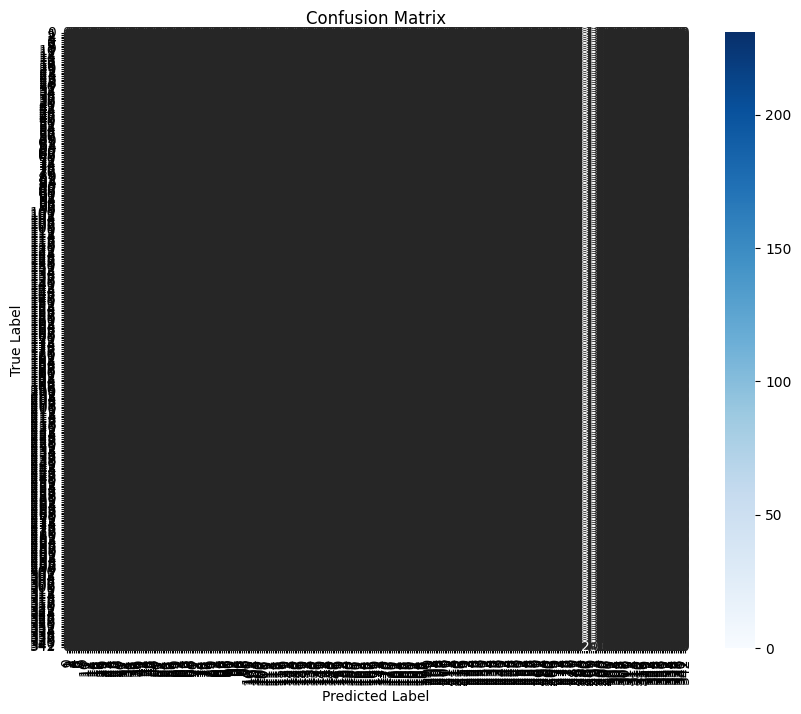

'\n# Precision-Recall Curve\nprecision_vals, recall_vals, _ = precision_recall_curve(all_labels, all_predictions, average=\'weighted\')\nplt.figure(figsize=(8, 6))\nplt.plot(recall_vals, precision_vals, marker=\'.\')\nplt.title(\'Precision-Recall Curve\')\nplt.xlabel(\'Recall\')\nplt.ylabel(\'Precision\')\nplt.show()\n\n# ROC Curve\nfpr = {}\ntpr = {}\nroc_auc = {}\n\nfor i in range(num_classes):\n    fpr[i], tpr[i], _ = roc_curve((all_labels == i).astype(int), (all_predictions == i).astype(int))\n    roc_auc[i] = auc(fpr[i], tpr[i])\n\nplt.figure(figsize=(8, 6))\nfor i in range(num_classes):\n    plt.plot(fpr[i], tpr[i], label=f\'Class {i} (area = {roc_auc[i]:.2f})\')\n\nplt.plot([0, 1], [0, 1], \'k--\')\nplt.title(\'ROC Curve\')\nplt.xlabel(\'False Positive Rate\')\nplt.ylabel(\'True Positive Rate\')\nplt.legend(loc="lower right")\nplt.show()\n\n# Classification Report\nreport = classification_report(all_labels, all_predictions, target_names=[f\'Class {i}\' for i in range(num_classes

In [ ]:
from sklearn.metrics import precision_score, recall_score, f1_score, confusion_matrix, classification_report, precision_recall_curve, roc_curve, auc
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import average_precision_score
import numpy as np

model.eval()
criterion = nn.CrossEntropyLoss()  # Same loss function used during training
total_loss = 0.0
correct_predictions = 0
total_samples = 0

all_labels = []
all_predictions = []
all_probs = []  # To store the predicted probabilities for mAP calculation

with torch.no_grad():  # Disable gradient computation for evaluation
    for batch_idx, (inputs, labels) in enumerate(test_loader):
        # Filter out out-of-bound labels
        valid_indices = labels < num_classes
        inputs = inputs[valid_indices]
        labels = labels[valid_indices]

        if len(labels) == 0:
            continue  # Skip batches with no valid labels

        # Forward pass
        outputs = model(inputs)
        loss = criterion(outputs, labels)  # Compute the loss

        total_loss += loss.item() * inputs.size(0)  # Accumulate the loss
        probs = torch.softmax(outputs, dim=1)  # Get the probabilities
        _, predicted = torch.max(outputs, 1)  # Get the index of the max log-probability
        correct_predictions += (predicted == labels).sum().item()  # Count correct predictions
        total_samples += labels.size(0)

        # Store all labels and predictions for metric calculation
        all_labels.extend(labels.cpu().numpy())
        all_predictions.extend(predicted.cpu().numpy())
        all_probs.extend(probs.cpu().numpy())  # Store probabilities for mAP calculation

# Calculate average loss and accuracy
average_loss = total_loss / total_samples
accuracy = correct_predictions / total_samples

# Calculate precision, recall, and f1 score
precision = precision_score(all_labels, all_predictions, average='weighted', zero_division=0)
recall = recall_score(all_labels, all_predictions, average='weighted')
f1 = f1_score(all_labels, all_predictions, average='weighted')

# Calculate mAP (One-vs-Rest)
all_labels_one_hot = np.eye(num_classes)[all_labels]  # Convert labels to one-hot encoding
mAP = average_precision_score(all_labels_one_hot, all_probs, average='macro')

# Print metrics
print(f'Average loss: {average_loss:.4f}')
print(f'Accuracy: {accuracy:.4f}')
print(f'Precision: {precision:.4f}')
print(f'Recall: {recall:.4f}')
print(f'F1 Score: {f1:.4f}')
print(f'mAP (One-vs-Rest): {mAP:.4f}')

# Confusion Matrix
cm = confusion_matrix(all_labels, all_predictions)
plt.figure(figsize=(10, 8))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=range(num_classes), yticklabels=range(num_classes))
plt.title('Confusion Matrix')
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.show()
'''
# Precision-Recall Curve
precision_vals, recall_vals, _ = precision_recall_curve(all_labels, all_predictions, average='weighted')
plt.figure(figsize=(8, 6))
plt.plot(recall_vals, precision_vals, marker='.')
plt.title('Precision-Recall Curve')
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.show()

# ROC Curve
fpr = {}
tpr = {}
roc_auc = {}

for i in range(num_classes):
    fpr[i], tpr[i], _ = roc_curve((all_labels == i).astype(int), (all_predictions == i).astype(int))
    roc_auc[i] = auc(fpr[i], tpr[i])

plt.figure(figsize=(8, 6))
for i in range(num_classes):
    plt.plot(fpr[i], tpr[i], label=f'Class {i} (area = {roc_auc[i]:.2f})')

plt.plot([0, 1], [0, 1], 'k--')
plt.title('ROC Curve')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.legend(loc="lower right")
plt.show()

# Classification Report
report = classification_report(all_labels, all_predictions, target_names=[f'Class {i}' for i in range(num_classes)])
print(report)
'''

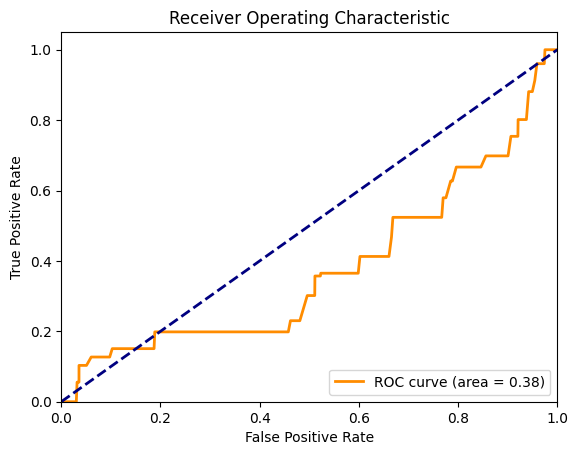

In [ ]:
from sklearn.metrics import roc_curve, auc

fpr, tpr, _ = roc_curve(all_labels, all_predictions, pos_label=1)
roc_auc = auc(fpr, tpr)

# Plot ROC curve
plt.figure()
plt.plot(fpr, tpr, color='darkorange', lw=2, label='ROC curve (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic')
plt.legend(loc="lower right")
plt.show()


In [ ]:
from sklearn.metrics import cohen_kappa_score

kappa = cohen_kappa_score(all_labels, all_predictions)
print(f'Cohen\'s Kappa: {kappa:.2f}')

Cohen's Kappa: 0.00


In [ ]:
from collections import Counter
import matplotlib.pyplot as plt

label_distribution = Counter(all_labels)
prediction_distribution = Counter(all_predictions)

print("Label Distribution:", label_distribution)
print("Prediction Distribution:", prediction_distribution)

# Plot the class distributionqwertyuiopasdfghjklzxcvbnmPOOOOOOOP HE POOPED HIS PANTSS nanashushu nanashushu nananananananananananashushu nanashushu nanashushu nananananananananananananananananananananananananananananana SHU SHUUUUUUUUUUUUU
#hhhhhhhh
plt.figure(figsize=(12, 6))

plt.subplot(1, 2, 1)
plt.bar(label_distribution.keys(), label_distribution.values(), color='blue')
plt.title("Label Distribution")
plt.xlabel("Class")
plt.ylabel("Frequency")

plt.subplot(1, 2, 2)
plt.bar(prediction_distribution.keys(), prediction_distribution.values(), color='red')
plt.title("Prediction Distribution")
plt.xlabel("Class")
plt.ylabel("Frequency")

plt.tight_layout()

NameError: name 'all_labels' is not defined

# VGGish

In [ ]:
!pip install torchvggish

In [ ]:
import torch
import torchaudio
from torch.utils.data import Dataset, DataLoader
import torchaudio.transforms as transforms
from torchvision import models
import torch.nn as nn
import torch.nn.functional as F
from torchvision.transforms import Resize

In [ ]:
class FSD50KDataset(Dataset):
    def __init__(self, csv_file, audio_dir, transform=None, max_len=1000):
        self.dataframe = pd.read_csv(csv_file)
        self.audio_dir = audio_dir
        self.transform = transform
        self.max_len = max_len

        # Encode string labels to integers
        label_to_idx = {label: idx for idx, label in enumerate(self.dataframe['single_label'].unique())}
        self.dataframe['encoded_label'] = self.dataframe['single_label'].map(label_to_idx)

    def __len__(self):
        return len(self.dataframe)

    def __getitem__(self, idx):
        audio_name = os.path.join(self.audio_dir, str(self.dataframe.iloc[idx, 0]) + '.wav')
        waveform, sample_rate = torchaudio.load(audio_name)

        if self.transform:
            waveform = self.transform(waveform)

        mel_spec = torchaudio.transforms.MelSpectrogram(
            sample_rate=sample_rate, n_mels=64, n_fft=1024, hop_length=512
        )(waveform)

        # Ensure the spectrogram has the correct shape (1 channel)
        mel_spec = mel_spec.mean(dim=0, keepdim=True)

        # Normalize the spectrogram
        mel_spec = (mel_spec - mel_spec.mean()) / mel_spec.std()

        # Pad or truncate the spectrogram to the max_len
        if mel_spec.size(-1) < self.max_len:
            padding = self.max_len - mel_spec.size(-1)
            mel_spec = F.pad(mel_spec, (0, padding))
        else:
            mel_spec = mel_spec[:, :, :self.max_len]

        # Repeat the single-channel spectrogram 3 times to simulate 3 channels
        mel_spec = mel_spec.repeat(3, 1, 1)

        label = self.dataframe.iloc[idx]['encoded_label']
        label = torch.tensor(label).long()  # Convert label to tensor

        return mel_spec, label

In [ ]:
class VGGishClassifier(nn.Module):
    def __init__(self, num_classes):
        super(VGGishClassifier, self).__init__()
        self.vggish = models.vgg16(pretrained=True)

        # Freeze the VGGish layers
        for param in self.vggish.parameters():
            param.requires_grad = False

        # Replace the classifier to fit your task
        self.vggish.classifier[-1] = nn.Linear(self.vggish.classifier[-1].in_features, num_classes)

    def forward(self, x):
        x = self.vggish(x)
        return x

In [ ]:
train_dataset = FSD50KDataset(csv_file=train_csv_path, audio_dir=train_audio_dir)
test_dataset = FSD50KDataset(csv_file=test_csv_path, audio_dir=test_audio_dir)

# Identifying and keeping top n classes
class_distribution = train_dataset.dataframe['encoded_label'].value_counts()
top_n_classes = class_distribution.head(50).index  # For example, keeping top 50 classes
filtered_df = train_dataset.dataframe[train_dataset.dataframe['encoded_label'].isin(top_n_classes)]
train_dataset.dataframe = filtered_df.reset_index(drop=True)

# Recalculate number of classes and remap labels
num_classes = len(filtered_df['encoded_label'].unique())
label_to_idx = {label: idx for idx, label in enumerate(filtered_df['encoded_label'].unique())}
train_dataset.dataframe['encoded_label'] = train_dataset.dataframe['encoded_label'].map(label_to_idx)


In [ ]:
'''
train_dataset = FSD50KDataset(
    csv_file=train_csv_path,
    audio_dir=train_audio_dir,
    transform=transforms.Resample(16000)  # Resample if needed
)
test_dataset = FSD50KDataset(
    csv_file=test_csv_path,
    audio_dir=test_audio_dir,
    transform=transforms.Resample(16000)
)
'''


# DataLoader
batch_size = 32
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, num_workers=4)


test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False, num_workers=4)



In [ ]:
print(train_dataset.dataframe.columns)

Index(['fname', 'single_label', 'mids', 'encoded_label'], dtype='object')


In [ ]:
num_classes = len(train_dataset.dataframe['encoded_label'].unique())
print(num_classes)

model = VGGishClassifier(num_classes=num_classes)
criterion = nn.CrossEntropyLoss(weight=class_weights)
optimizer = torch.optim.Adam(model.parameters(), lr=1e-5)

50


/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=VGG16_Weights.IMAGENET1K_V1`. You can also use `weights=VGG16_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


In [ ]:
print(f"Unique labels in training data: {train_dataset.dataframe['encoded_label'].unique()}")

Unique labels in training data: [ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23
 24 25 26 27 28 29 30 31 32 33 34 35 36 37 38 39 40 41 42 43 44 45 46 47
 48 49]


In [ ]:
print("Minimum label value:", train_dataset.dataframe['encoded_label'].min())
print("Maximum label value:", train_dataset.dataframe['encoded_label'].max())

Minimum label value: 0
Maximum label value: 49


In [ ]:
unique_labels = train_dataset.dataframe['encoded_label'].unique()
print(f"Unique labels in the dataset: {unique_labels}")
print(f"Number of unique labels: {len(unique_labels)}")

Unique labels in the dataset: [ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23
 24 25 26 27 28 29 30 31 32 33 34 35 36 37 38 39 40 41 42 43 44 45 46 47
 48 49]
Number of unique labels: 50


In [ ]:
for inputs, labels in train_loader:
    print(f"Sample inputs: {inputs}")
    print(f"Sample labels: {labels}")
    break

Sample inputs: tensor([[[[-0.2601, -0.2598, -0.2598,  ...,  0.0000,  0.0000,  0.0000],
          [-0.2598, -0.2506, -0.2561,  ...,  0.0000,  0.0000,  0.0000],
          [-0.2595, -0.2394, -0.2413,  ...,  0.0000,  0.0000,  0.0000],
          ...,
          [-0.2603, -0.2602, -0.2602,  ...,  0.0000,  0.0000,  0.0000],
          [-0.2603, -0.2602, -0.2603,  ...,  0.0000,  0.0000,  0.0000],
          [-0.2603, -0.2603, -0.2603,  ...,  0.0000,  0.0000,  0.0000]],

         [[-0.2601, -0.2598, -0.2598,  ...,  0.0000,  0.0000,  0.0000],
          [-0.2598, -0.2506, -0.2561,  ...,  0.0000,  0.0000,  0.0000],
          [-0.2595, -0.2394, -0.2413,  ...,  0.0000,  0.0000,  0.0000],
          ...,
          [-0.2603, -0.2602, -0.2602,  ...,  0.0000,  0.0000,  0.0000],
          [-0.2603, -0.2602, -0.2603,  ...,  0.0000,  0.0000,  0.0000],
          [-0.2603, -0.2603, -0.2603,  ...,  0.0000,  0.0000,  0.0000]],

         [[-0.2601, -0.2598, -0.2598,  ...,  0.0000,  0.0000,  0.0000],
          [-0.2

In [ ]:
from torch.optim.lr_scheduler import StepLR

num_epochs = 5

from torch.nn.utils import clip_grad_norm_

# Set your optimizer and scheduler as before
optimizer = torch.optim.Adam(model.parameters(), lr=1e-5)
scheduler = StepLR(optimizer, step_size=5, gamma=0.1)

# Training loop
for epoch in range(num_epochs):
    model.train()
    running_loss = 0.0

    for batch_idx, (inputs, labels) in enumerate(train_loader):
        optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs, labels)
        loss.backward()

        # Clip gradients to prevent exploding gradients
        clip_grad_norm_(model.parameters(), max_norm=1.0)

        optimizer.step()
        running_loss += loss.item()

        if batch_idx % 10 == 0:
            print(f"Batch {batch_idx}/{len(train_loader)} - Loss: {loss.item():.4f}")

    print(f"Epoch [{epoch+1}/{num_epochs}], Loss: {running_loss/len(train_loader):.4f}")
    scheduler.step()

Batch 0/586 - Loss: 4.2128
Batch 10/586 - Loss: 3.9996
Batch 20/586 - Loss: 3.9082
Batch 30/586 - Loss: nan
Batch 40/586 - Loss: nan
Batch 50/586 - Loss: nan


KeyboardInterrupt: 

In [ ]:
!pip install torch
!pip install torchaudio
!pip install torchvision
!pip install torch-audiomentations

  Using cached torch_audiomentations-0.11.1-py3-none-any.whl.metadata (14 kB)
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 59.6/59.6 kB 4.0 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 50.1/50.1 kB 3.7 MB/s eta 0:00:00
  Created wheel for julius: filename=julius-0.2.7-py3-none-any.whl size=21869 sha256=223370929b8614b6f1284e27f6f66bb99ab9dec7eb1f40bb1f82bc597cd9dab3
  Stored in directory: /root/.cache/pip/wheels/b9/b2/05/f883527ffcb7f2ead5438a2c23439aa0c881eaa9a4c80256f4
Successfully built julius


In [ ]:
!pip install imbalanced-learn

In [ ]:
import torch
import torchaudio
from torch.utils.data import Dataset, DataLoader
import pandas as pd
from torchvision import models
import torch.nn as nn
from imblearn.over_sampling import RandomOverSampler

In [ ]:
class FSD50KDataset(Dataset):
    def __init__(self, csv_file, audio_dir, transform=None, max_len=1000):
        self.dataframe = pd.read_csv(csv_file)
        self.audio_dir = audio_dir
        self.transform = transform
        self.max_len = max_len

        # Encode string labels to integers
        label_to_idx = {label: idx for idx, label in enumerate(self.dataframe['single_label'].unique())}
        self.dataframe['encoded_label'] = self.dataframe['single_label'].map(label_to_idx)

        # Filter to keep only the top 50 classes
        top_n_classes = self.dataframe['encoded_label'].value_counts().head(50).index
        self.dataframe = self.dataframe[self.dataframe['encoded_label'].isin(top_n_classes)]
        self.dataframe.reset_index(drop=True, inplace=True)

        # Re-encode labels after filtering
        label_to_idx = {label: idx for idx, label in enumerate(self.dataframe['encoded_label'].unique())}
        self.dataframe['encoded_label'] = self.dataframe['encoded_label'].map(label_to_idx)

        # Separate features and labels for oversampling
        X = self.dataframe.drop('encoded_label', axis=1)
        y = self.dataframe['encoded_label']

        # Perform oversampling
        ros = RandomOverSampler()
        X_resampled, y_resampled = ros.fit_resample(X, y)

        # Combine the resampled features and labels back into a DataFrame
        self.dataframe = X_resampled.copy()
        self.dataframe['encoded_label'] = y_resampled

    def __len__(self):
        return len(self.dataframe)

    def __getitem__(self, idx):
        # The rest of your __getitem__ method
        audio_name = os.path.join(self.audio_dir, str(self.dataframe.iloc[idx, 0]) + '.wav')
        waveform, sample_rate = torchaudio.load(audio_name)

        if self.transform:
            waveform = self.transform(waveform)

        mel_spec = torchaudio.transforms.MelSpectrogram(
            sample_rate=sample_rate, n_mels=64, n_fft=1024, hop_length=512)(waveform)

        mel_spec = mel_spec.mean(dim=0, keepdim=True)
        mel_spec = (mel_spec - mel_spec.mean()) / (mel_spec.std() + 1e-6)

        if mel_spec.size(-1) < self.max_len:
            padding = self.max_len - mel_spec.size(-1)
            mel_spec = nn.functional.pad(mel_spec, (0, padding))
        else:
            mel_spec = mel_spec[:, :, :self.max_len]

        mel_spec = nn.functional.interpolate(mel_spec.unsqueeze(0), size=(224, 224), mode='bilinear', align_corners=False).squeeze(0)
        mel_spec = mel_spec.repeat(3, 1, 1)

        label = torch.tensor(self.dataframe.iloc[idx]['encoded_label']).long()
        return mel_spec, label

In [ ]:
class VGGishClassifier(nn.Module):
    def __init__(self, num_classes):
        super(VGGishClassifier, self).__init__()
        self.vggish = models.vgg16(pretrained=True)

        # Freeze the VGGish layers
        for param in self.vggish.parameters():
            param.requires_grad = False

        # Replace the classifier to fit your task
        self.vggish.classifier[-1] = nn.Linear(self.vggish.classifier[-1].in_features, num_classes)

    def forward(self, x):
        x = self.vggish(x)
        return x

In [ ]:
def set_bn_eval(m):
    if isinstance(m, torch.nn.modules.batchnorm._BatchNorm):
        m.eval()
        m.weight.requires_grad = False
        m.bias.requires_grad = False

In [ ]:
import torch.optim as optim
from torch.optim.lr_scheduler import StepLR
from torch.nn.utils import clip_grad_norm_

model = VGGishClassifier(num_classes=50)

model.apply(set_bn_eval)

# Hyperparameters
num_epochs = 10
learning_rate = 1e-4
batch_size = 32

# Create the dataset and data loader
train_dataset = FSD50KDataset(csv_file=train_csv_sampled_path, audio_dir=train_audio_dir)
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, num_workers=4)

/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=VGG16_Weights.IMAGENET1K_V1`. You can also use `weights=VGG16_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/vgg16-397923af.pth" to /root/.cache/torch/hub/checkpoints/vgg16-397923af.pth
100%|██████████| 528M/528M [00:03<00:00, 152MB/s]


In [ ]:
from sklearn.utils.class_weight import compute_class_weight
import numpy as np

labels = train_dataset.dataframe['encoded_label']
class_weights = compute_class_weight(class_weight='balanced', classes=np.unique(labels), y=labels)
class_weights = torch.tensor(class_weights, dtype=torch.float32)

print(class_weights)

tensor([1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
        1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
        1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.])


In [ ]:
criterion = nn.CrossEntropyLoss(weight=class_weights)
optimizer = optim.Adam(model.parameters(), lr=learning_rate)
scheduler = StepLR(optimizer, step_size=5, gamma=0.1)

In [ ]:
for epoch in range(num_epochs):
    model.train()  # Ensure model is in training mode
    running_loss = 0.0

    for batch_idx, (inputs, labels) in enumerate(train_loader):
        optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs, labels)
        loss.backward()

        # Clip gradients to prevent exploding gradients
        clip_grad_norm_(model.parameters(), max_norm=1.0)

        optimizer.step()
        running_loss += loss.item()

        if batch_idx % 10 == 0:
            print(f"Batch {batch_idx}/{len(train_loader)} - Loss: {loss.item():.4f}")

    print(f"Epoch [{epoch+1}/{num_epochs}], Loss: {running_loss/len(train_loader):.4f}")
    scheduler.step()

/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


Batch 0/530 - Loss: 4.0560
Batch 10/530 - Loss: 3.9648
Batch 20/530 - Loss: 4.0001
Batch 30/530 - Loss: 3.8539
Batch 40/530 - Loss: 3.9172
Batch 50/530 - Loss: 3.7336
Batch 60/530 - Loss: 3.6403
Batch 70/530 - Loss: 3.7384
Batch 80/530 - Loss: 3.6359
Batch 90/530 - Loss: 3.4025
Batch 100/530 - Loss: 3.4955
Batch 110/530 - Loss: 3.5186
Batch 120/530 - Loss: 3.4355
Batch 130/530 - Loss: 3.5215
Batch 140/530 - Loss: 3.1930
Batch 150/530 - Loss: 3.2358
Batch 160/530 - Loss: 3.1667
Batch 170/530 - Loss: 3.0746
Batch 180/530 - Loss: 3.3141
Batch 190/530 - Loss: 3.2442
Batch 200/530 - Loss: 3.4303
Batch 210/530 - Loss: 3.1767
Batch 220/530 - Loss: 3.1027
Batch 230/530 - Loss: 2.9856
Batch 240/530 - Loss: 3.3605
Batch 250/530 - Loss: 3.4466
Batch 260/530 - Loss: 3.1790
Batch 270/530 - Loss: 2.9770
Batch 280/530 - Loss: 3.1853
Batch 290/530 - Loss: 2.9719
Batch 300/530 - Loss: 2.9979
Batch 310/530 - Loss: 3.0729
Batch 320/530 - Loss: 2.9990
Batch 330/530 - Loss: 2.9625
Batch 340/530 - Loss: 2.7

In [ ]:
model_save_path = '/content/drive/MyDrive/Thesis/FSD50K/vggish_trained_audio_model.pth' #dbbjedjdssssnnnnnndddddddnnjjjjddddjjjfffffbbbhhhddddccccdddocbrucebannerpeltedbygammaraysturnedintothehulkAINTHEJESRFRKHFEJDRJSbhhh
torch.save(model.state_dict(), model_save_path)
print(f"Model saved to {model_save_path}")

Model saved to /content/drive/MyDrive/Thesis/FSD50K/vggish_trained_audio_model.pth


In [ ]:
test_dataset = FSD50KDataset(csv_file=test_csv_path, audio_dir=test_audio_dir) #kkkkjjjjgggfffnnhhgggggghhgddddddbbbbddddsssggggguuuudddhhhggg
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False, num_workers=4)

In [ ]:
unique_labels = test_dataset.dataframe['encoded_label'].unique()
print(f"Unique labels in the dataset: {unique_labels}")
print(f"Number of unique labels: {len(unique_labels)}")

Unique labels in the dataset: [ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23
 24 25 26 27 28 29 30 31 32 33 34 35 36 37 38 39 40 41 42 43 44 45 46 47
 48 49]
Number of unique labels: 50


In [ ]:
from sklearn.metrics import confusion_matrix, classification_report, precision_recall_fscore_support
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np

In [ ]:
class_names = test_dataset.dataframe['single_label'].unique().tolist()

/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


Accuracy: 2.52%


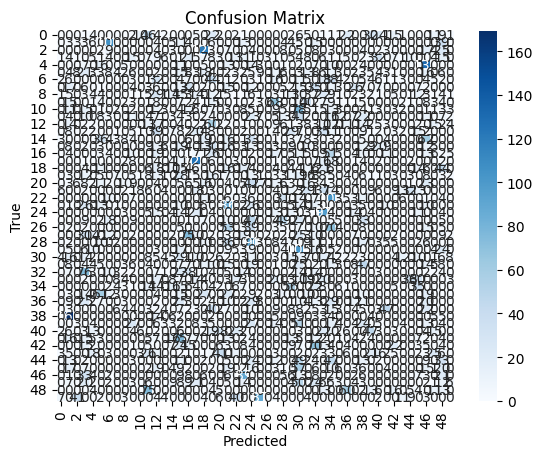

Class: Electric_guitar - Precision: 0.00, Recall: 0.00, F1-Score: 0.00
Class: Snare_drum - Precision: 0.01, Recall: 0.01, F1-Score: 0.01
Class: Hi-hat - Precision: 0.00, Recall: 0.00, F1-Score: 0.00
Class: Synthesizer - Precision: 0.00, Recall: 0.00, F1-Score: 0.00
Class: Coin_(dropping) - Precision: 0.00, Recall: 0.00, F1-Score: 0.00
Class: Dishes_and_pots_and_pans - Precision: 0.01, Recall: 0.01, F1-Score: 0.01
Class: Chatter - Precision: 0.00, Recall: 0.00, F1-Score: 0.00
Class: Splash_and_splatter - Precision: 0.00, Recall: 0.00, F1-Score: 0.00
Class: Male_speech_and_man_speaking - Precision: 0.00, Recall: 0.00, F1-Score: 0.00
Class: Chirp_and_tweet - Precision: 0.02, Recall: 0.01, F1-Score: 0.02
Class: Walk_and_footsteps - Precision: 0.00, Recall: 0.00, F1-Score: 0.00
Class: Tap - Precision: 0.02, Recall: 0.02, F1-Score: 0.02
Class: Engine - Precision: 0.05, Recall: 0.07, F1-Score: 0.06
Class: Female_speech_and_woman_speaking - Precision: 0.00, Recall: 0.00, F1-Score: 0.00
Class: 

In [ ]:
model.eval()
correct = 0
total = 0
all_labels = []
all_predictions = []

with torch.no_grad():
    for inputs, labels in test_loader:
        outputs = model(inputs)
        _, predicted = torch.max(outputs, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()
        all_labels.extend(labels.cpu().numpy())
        all_predictions.extend(predicted.cpu().numpy())

# Calculate accuracy
accuracy = 100 * correct / total
print(f'Accuracy: {accuracy:.2f}%')

# Generate confusion matrix
cm = confusion_matrix(all_labels, all_predictions)
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix')
plt.show()


# Precision, Recall, F1-Score for each class
precision, recall, f1_score, _ = precision_recall_fscore_support(all_labels, all_predictions, average=None)
for i, class_name in enumerate(class_names):
    print(f"Class: {class_name} - Precision: {precision[i]:.2f}, Recall: {recall[i]:.2f}, F1-Score: {f1_score[i]:.2f}")

# Overall Precision, Recall, F1-Score (Macro Average)
precision, recall, f1_score, _ = precision_recall_fscore_support(all_labels, all_predictions, average='macro')
print(f"Overall (Macro) - Precision: {precision:.2f}, Recall: {recall:.2f}, F1-Score: {f1_score:.2f}")

# Overall Precision, Recall, F1-Score (Weighted Average)
precision, recall, f1_score, _ = precision_recall_fscore_support(all_labels, all_predictions, average='weighted')
print(f"Overall (Weighted) - Precision: {precision:.2f}, Recall: {recall:.2f}, F1-Score: {f1_score:.2f}")



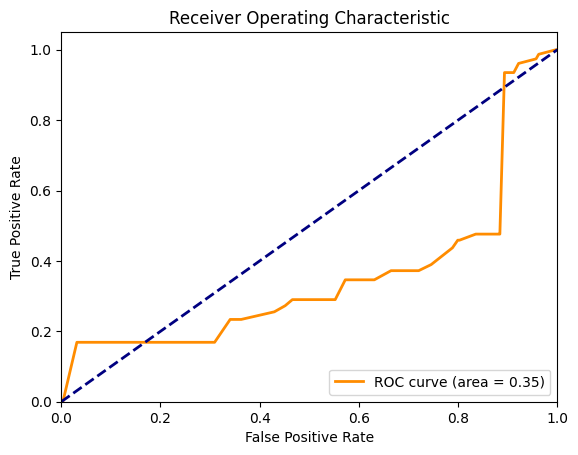

In [ ]:
from sklearn.metrics import roc_curve, auc

fpr, tpr, _ = roc_curve(all_labels, all_predictions, pos_label=1)
roc_auc = auc(fpr, tpr)

# Plot ROC curve
plt.figure()
plt.plot(fpr, tpr, color='darkorange', lw=2, label='ROC curve (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic')
plt.legend(loc="lower right")
plt.show()

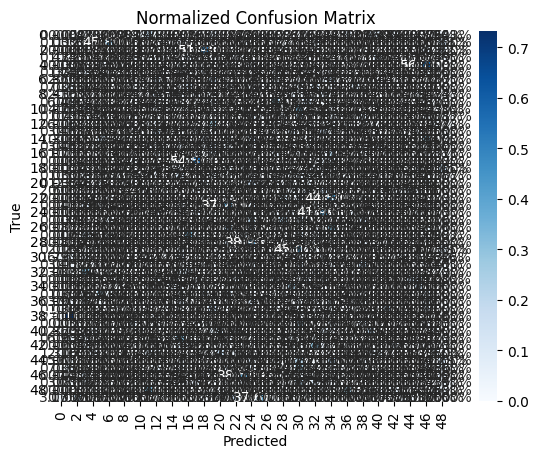

In [ ]:
sns.heatmap(cm.astype('float') / cm.sum(axis=1)[:, np.newaxis], annot=True, fmt='.2%', cmap='Blues')
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Normalized Confusion Matrix')
plt.show()

In [ ]:
from sklearn.metrics import cohen_kappa_score

kappa = cohen_kappa_score(all_labels, all_predictions)
print(f'Cohen\'s Kappa: {kappa:.2f}')

Cohen's Kappa: 0.01


# YAMNet

In [ ]:
!pip install tensorflow tensorflow-hub #jjjjjjgggggggggghhhhhhhhrrrrrrrrrrrtttthh

In [ ]:
import tensorflow as tf
import tensorflow_hub as hub
import pandas as pd
import numpy as np
from sklearn.utils import class_weight
from imblearn.over_sampling import RandomOverSampler
from sklearn.model_selection import train_test_split

In [ ]:
yamnet_model_handle = 'https://tfhub.dev/google/yamnet/1'
yamnet_model = hub.load(yamnet_model_handle)

In [ ]:
# Load and prepare your CSV data
train_df = pd.read_csv(train_csv_path)
train_df = train_df.sample(n=20483, random_state=42)  # Adjust as needed
train_filenames = train_df['fname'].astype(str).values

# Function to load and preprocess audio data
import librosa

def load_and_preprocess_audio(filename, label):
    # Convert TensorFlow Tensor to string if necessary
    if isinstance(filename, tf.Tensor):
        filename = tf.compat.as_str_any(filename.numpy())

    audio_path = os.path.join(train_audio_dir, filename + '.wav')

    # Load and resample using librosa
    waveform, _ = librosa.load(audio_path, sr=16000)  # Ensures 16 kHz sample rate

    # Normalize waveform
    waveform = (waveform - waveform.mean()) / waveform.max()

    # Ensure the waveform is exactly 16000 samples long
    if len(waveform) < 16000:
        waveform = np.pad(waveform, (0, 16000 - len(waveform)), mode='constant')
    elif len(waveform) > 16000:
        waveform = waveform[:16000]

    return tf.convert_to_tensor(waveform, dtype=tf.float32), label

def load_and_preprocess_audio_wrapper(filename, label):
    waveform, label = tf.py_function(
        load_and_preprocess_audio,
        [filename, label],
        [tf.float32, tf.int32]  # Ensure output types are correctly specified
    )
    label = tf.cast(label, tf.int32)  # Cast label to int32
    return waveform, label


In [ ]:
print(train_df.columns)

Index(['fname', 'single_label', 'mids'], dtype='object')


In [ ]:
from sklearn.preprocessing import LabelEncoder

le = LabelEncoder()
train_df['encoded_label'] = le.fit_transform(train_df['single_label'])

In [ ]:
train_filenames = train_df['fname'].values
train_labels = train_df['encoded_label'].values

train_dataset = tf.data.Dataset.from_tensor_slices((train_filenames, train_labels.astype(np.int32)))
train_dataset = train_dataset.map(load_and_preprocess_audio_wrapper)
train_loader = train_dataset.shuffle(buffer_size=1024).batch(32)

In [ ]:
class YAMNetClassifier(tf.keras.Model):
    def __init__(self, num_classes):
        super(YAMNetClassifier, self).__init__()
        self.yamnet_model = hub.KerasLayer("https://tfhub.dev/google/yamnet/1", trainable=False)
        self.global_avg_pool = tf.keras.layers.GlobalAveragePooling1D()
        self.fc = tf.keras.layers.Dense(num_classes)

    def call(self, inputs, training=False):
        embeddings, _, _ = self.yamnet_model(inputs)  # Get embeddings from YAMNet
        pooled_embeddings = self.global_avg_pool(embeddings)  # Pool the embeddings
        return self.fc(pooled_embeddings)  # Pass through final dense layer

In [ ]:
class SimpleModel(tf.keras.Model):
    def __init__(self, num_classes):
        super(SimpleModel, self).__init__()
        self.fc = tf.keras.layers.Dense(num_classes)

    def call(self, inputs):
        print("Input shape:", inputs.shape)
        return self.fc(inputs)



In [ ]:
from sklearn.preprocessing import LabelEncoder

le = LabelEncoder()
train_df['encoded_label'] = le.fit_transform(train_df['single_label'])
num_classes = len(le.classes_)

print(num_classes)

343


In [ ]:
print(train_df['encoded_label'].unique())

[ 74 179 294  39 177 157 315 258 107 316 245 262  50   7 268 275 199 173
  97 103 229 288 148 239 139  84 115 270 187   5  68 138 253  23  26 282
 322  66 242 108 326 186 303 341 182  33 321 161 248 325 146 143 300 333
 116 167 331  18 164 124 332 338 305 195   2 240 117 334 241 287 254 216
 211  22 154 285  44 335  56 147 172  60  11 228 190 286 145 311 295  19
  30  76 297 292 314 230  73  29 125 214 232 324  28 169 123  15 180  67
 105 101 109  12 178 133 342 328  62  36  53 218 293  94 183  88 308  91
 272 271 153 129  54  93 140 152 206  71 243 181 104   0 301  83  37 150
 246   9 165  49 312 219 120 192  25 251 304  85 135  72  57 202 269 149
  86 223  79 263 122 280 198 306 329  20 299  96 291  46 159  87  32 156
 110 112 289 160 193 213 259 134 281 318 256 278 298  38   6  59 163 174
 222 200 221 151  58 168 273 144 336 224 128 121  80   1 175 185 208 212
 234  51 266 247 319  90  35 237 320  70  21 235 127 162 225  48  61 265
  78 310 100  41  27 290  16 260 309 252 250 302  6

In [ ]:
model = YAMNetClassifier(num_classes=num_classes)

In [ ]:
model.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=1e-4),
    loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
    metrics=['accuracy']
)

In [ ]:
for data, label in train_loader.take(1):
    print(data.shape, label.shape)

(32, 16000) (32,)


In [ ]:
sample_data, sample_label = next(iter(train_loader))
output = model(sample_data)

print(f"Output shape: {output.shape}")

Input shape: (32, 16000)
Input shape: (32, 16000)
Output shape: (32, 50)


In [ ]:
print("TensorFlow version:", tf.__version__)
print("TensorFlow Hub version:", hub.__version__)

TensorFlow version: 2.17.0
TensorFlow Hub version: 0.16.1


In [ ]:
single_sample_data = tf.reshape(single_sample_data, [1, 16000])

# Ensure data type is float32
single_sample_data = tf.cast(single_sample_data, dtype=tf.float32)

# Pass through YAMNet
output = model(single_sample_data)

# Print output shape
print(f"Single sample model output shape: {output.shape}")

TypeError: Exception encountered when calling layer 'keras_layer_19' (type KerasLayer).

Binding inputs to tf.function failed due to `Can not cast TensorSpec(shape=(1, 16000), dtype=tf.float32, name=None) to TensorSpec(shape=(None,), dtype=tf.float32, name=None)`. Received args: (<tf.Tensor: shape=(1, 16000), dtype=float32, numpy=
array([[-0.00112632, -0.00146833,  0.00059071, ..., -0.06068995,
        -0.03618046, -0.01944895]], dtype=float32)>,) and kwargs: {} for signature: (waveform: TensorSpec(shape=(None,), dtype=tf.float32, name=None)).

Call arguments received by layer 'keras_layer_19' (type KerasLayer):
  • inputs=tf.Tensor(shape=(1, 16000), dtype=float32)
  • training=None

In [ ]:
sample_data, _ = next(iter(train_loader))
print(f"Sample data shape before model: {sample_data.shape}")

# Ensure correct shape and dtype
sample_data = tf.ensure_shape(sample_data, (None, 16000))
sample_data = tf.cast(sample_data, tf.float32)

# Pass through YAMNet model
output = model(sample_data)
print(f"Model output shape: {output.shape}")

Sample data shape before model: (32, 16000)
Model output shape: (32, 1024, 343)


In [ ]:
epochs = 10

for epoch in range(epochs):
    print(f"Epoch {epoch+1}/{epochs}")
    for step, (data, labels) in enumerate(train_loader):
        with tf.GradientTape() as tape:
            predictions = model(data)
            loss = tf.keras.losses.sparse_categorical_crossentropy(labels, predictions, from_logits=True)

        gradients = tape.gradient(loss, model.trainable_variables)
        optimizer.apply_gradients(zip(gradients, model.trainable_variables))

        if step % 100 == 0:
            print(f"Step {step}, Loss: {tf.reduce_mean(loss).numpy()}")

Epoch 1/10


ValueError: Argument `output` must have rank (ndim) `target.ndim - 1`. Received: target.shape=(32,), output.shape=(32, 1024, 343)

## Unsupervised

In [ ]:
class ConvAutoencoder(nn.Module): #jjjjjjjhh
    def __init__(self):
        super(ConvAutoencoder, self).__init__()
        # Encoder
        self.encoder = nn.Sequential(
            nn.Conv2d(1, 16, kernel_size=3, stride=2, padding=1),
            nn.ReLU(True),
            nn.Conv2d(16, 32, kernel_size=3, stride=2, padding=1),
            nn.ReLU(True),
            nn.Conv2d(32, 64, kernel_size=3, stride=2, padding=1),
            nn.ReLU(True)
        )
        # Decoder
        self.decoder = nn.Sequential(
            nn.ConvTranspose2d(64, 32, kernel_size=3, stride=2, padding=1, output_padding=1),
            nn.ReLU(True),
            nn.ConvTranspose2d(32, 16, kernel_size=3, stride=2, padding=1, output_padding=1),
            nn.ReLU(True),
            nn.ConvTranspose2d(16, 1, kernel_size=3, stride=2, padding=1, output_padding=1),
            nn.Sigmoid()
        )

    def forward(self, x):
        x = self.encoder(x)
        x = self.decoder(x)
        return x

In [ ]:
class FSD50KDatasetUSP(Dataset):
    def __init__(self, csv_file, audio_dir, transform=None):
        self.dataframe = pd.read_csv(csv_file)
        self.audio_dir = audio_dir
        self.transform = transform

    def __len__(self):
        return len(self.dataframe)

    def __getitem__(self, idx):
        audio_name = os.path.join(self.audio_dir, str(self.dataframe.iloc[idx, 0]) + '.wav')
        waveform, sample_rate = torchaudio.load(audio_name)

        if self.transform:
            waveform = self.transform(waveform)

            # Normalize the waveform to the range [0, 1]
            waveform = (waveform - waveform.min()) / (waveform.max() - waveform.min())

        return waveform

In [ ]:
def pad_collate_fn(batch):
    # Find the longest sequence in the batch
    max_len = max(item[0].size(-1) for item in batch)

    # Pad the sequences to the same length
    padded_batch = []
    for data in batch:
        waveform, = data  # Unpack the data tuple
        padding = max_len - waveform.size(-1)
        if padding > 0:
            waveform = F.pad(waveform, (0, padding), "constant", 0)
        padded_batch.append((waveform,))

    # Stack the padded sequences
    batch = torch.stack([item[0] for item in padded_batch])
    return batch,  # Return as a tuple to match the expected input formatjjjjjjjjjjjjjjjjjjj

In [ ]:
label_distribution = train_df['single_label'].value_counts()
print(label_distribution)

single_label
Snare_drum                 339
Laughter                   326
Clarinet                   310
Saxophone                  299
Cello                      282
                          ... 
Air_horn_and_truck_horn      1
Caw                          1
Squawk                       1
Arrow                        1
Foghorn                      1
Name: count, Length: 343, dtype: int64


In [ ]:
class_weights = 1. / label_distribution
class_weights = class_weights / class_weights.sum()  # Normalize so that weights sum to 1
class_weights = torch.tensor(class_weights.values, dtype=torch.float32)

print("Class Weights:", class_weights)

Class Weights: tensor([7.3974e-05, 7.6924e-05, 8.0894e-05, 8.3870e-05, 8.8926e-05, 9.1858e-05,
        9.2878e-05, 9.5714e-05, 9.5714e-05, 1.0236e-04, 1.0320e-04, 1.0809e-04,
        1.0999e-04, 1.1451e-04, 1.2602e-04, 1.2926e-04, 1.3339e-04, 1.3339e-04,
        1.3629e-04, 1.3703e-04, 1.4495e-04, 1.4665e-04, 1.4665e-04, 1.4839e-04,
        1.5016e-04, 1.5198e-04, 1.5673e-04, 1.5973e-04, 1.6075e-04, 1.6390e-04,
        1.6607e-04, 1.6830e-04, 1.6830e-04, 1.6830e-04, 1.6944e-04, 1.6944e-04,
        1.7536e-04, 1.7660e-04, 1.7660e-04, 1.7660e-04, 1.7785e-04, 1.8172e-04,
        1.8172e-04, 1.8304e-04, 1.8304e-04, 1.9143e-04, 1.9592e-04, 1.9746e-04,
        1.9902e-04, 2.0062e-04, 2.0062e-04, 2.0725e-04, 2.0898e-04, 2.1073e-04,
        2.1073e-04, 2.1252e-04, 2.1618e-04, 2.1806e-04, 2.1997e-04, 2.2390e-04,
        2.2592e-04, 2.2592e-04, 2.2592e-04, 2.3007e-04, 2.3220e-04, 2.3658e-04,
        2.3658e-04, 2.3658e-04, 2.3883e-04, 2.3883e-04, 2.4347e-04, 2.5330e-04,
        2.5330e-04, 2.585

In [ ]:
batch_size = 32

transform = transforms.MelSpectrogram(sample_rate=16000, n_fft=1024, hop_length=512)
train_dataset = FSD50KDatasetUSP(csv_file=train_csv_sampled_path, audio_dir=train_audio_dir, transform=transform)
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, collate_fn=pad_collate_fn, num_workers=4, pin_memory=True)

In [ ]:
model = ConvAutoencoder()
criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=1e-3)

In [ ]:
import torch.optim.lr_scheduler as lr_scheduler

scheduler = lr_scheduler.StepLR(optimizer, step_size=5, gamma=0.1)

num_epochs = 3

for epoch in range(num_epochs):
    model.train()
    running_loss = 0.0
    for batch_idx, data in enumerate(train_loader):
        data = data[0]  # Extract the waveform from the tuple

        # Print shape for debugging
        #print(f"Batch {batch_idx} - Original Data Shape: {data.shape}")

        # Reshape to the correct shape: (batch_size, 1, height, width)
        data = data.view(data.size(0), 1, data.size(-2), data.size(-1))  # Reshape appropriately

        optimizer.zero_grad()
        outputs = model(data)

        # Print output shape for debugging
        #print(f"Batch {batch_idx} - Outputs Shape: {outputs.shape}")

        # Pad the input to match the size of the output
        if outputs.size(-1) > data.size(-1):
            padding = outputs.size(-1) - data.size(-1)
            data = F.pad(data, (0, padding))
            #print(f"Batch {batch_idx} - Data after Padding Shape: {data.shape}")

        loss = criterion(outputs, data)
        loss.backward()
        optimizer.step()

        running_loss += loss.item()
        print(f"Batch {batch_idx} - Loss: {loss.item():.4f}")

    # Step the scheduler
    scheduler.step()

    print(f'Epoch [{epoch+1}/{num_epochs}], Loss: {running_loss/len(train_loader):.4f}, Learning Rate: {scheduler.get_last_lr()[0]}')

Batch 0 - Loss: 0.0092
Batch 1 - Loss: 0.0068
Batch 2 - Loss: 0.0053
Batch 3 - Loss: 0.0037
Batch 4 - Loss: 0.0028
Batch 5 - Loss: 0.0020
Batch 6 - Loss: 0.0014
Batch 7 - Loss: 0.0011
Batch 8 - Loss: 0.0008
Batch 9 - Loss: 0.0008
Batch 10 - Loss: 0.0009
Batch 11 - Loss: 0.0004
Batch 12 - Loss: 0.0003
Batch 13 - Loss: 0.0002
Batch 14 - Loss: 0.0004
Batch 15 - Loss: 0.0002
Batch 16 - Loss: 0.0005
Batch 17 - Loss: 0.0002
Batch 18 - Loss: 0.0003
Batch 19 - Loss: 0.0001
Batch 20 - Loss: 0.0002
Batch 21 - Loss: 0.0001
Batch 22 - Loss: 0.0002
Batch 23 - Loss: 0.0003
Batch 24 - Loss: 0.0000
Batch 25 - Loss: 0.0002
Batch 26 - Loss: 0.0001
Batch 27 - Loss: 0.0001
Batch 28 - Loss: 0.0002
Batch 29 - Loss: 0.0003
Batch 30 - Loss: 0.0002
Batch 31 - Loss: 0.0002
Batch 32 - Loss: 0.0001
Batch 33 - Loss: 0.0001
Batch 34 - Loss: 0.0002
Batch 35 - Loss: 0.0002
Batch 36 - Loss: 0.0002
Batch 37 - Loss: 0.0003
Batch 38 - Loss: 0.0001
Batch 39 - Loss: 0.0001
Batch 40 - Loss: 0.0001
Batch 41 - Loss: 0.0003
Ba

In [ ]:
# Define the path where you want to save the modelffffffffffffffffffggdddjjjjjjjbbbbbbbbbhhhhhhhhhbbbbbvvvvv
model_save_path = '/content/drive/MyDrive/Thesis/FSD50K/autoencoder_model5.pth'

# Save the model state_dict
torch.save(model.state_dict(), model_save_path)

print(f"Model saved to {model_save_path}")

Model saved to /content/drive/MyDrive/Thesis/FSD50K/autoencoder_model5.pth


In [ ]:
test_dataset = FSD50KDatasetUSP(csv_file=test_csv_sampled_path, audio_dir=test_audio_dir, transform=transform)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False, collate_fn=pad_collate_fn, num_workers=4, pin_memory=True)

In [ ]:
autoencoder = ConvAutoencoder()
autoencoder.load_state_dict(torch.load('/content/drive/MyDrive/Thesis/FSD50K/autoencoder_model5.pth'))
autoencoder.eval()

<ipython-input-28-695a9de84724>:2: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  autoencoder.load_state_dict(torch.load('/content/drive/MyDrive/Thesis/FSD50K/autoencoder_mod

ConvAutoencoder(
  (encoder): Sequential(
    (0): Conv2d(1, 16, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
    (1): ReLU(inplace=True)
    (2): Conv2d(16, 32, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
    (3): ReLU(inplace=True)
    (4): Conv2d(32, 64, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
    (5): ReLU(inplace=True)
  )
  (decoder): Sequential(
    (0): ConvTranspose2d(64, 32, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), output_padding=(1, 1))
    (1): ReLU(inplace=True)
    (2): ConvTranspose2d(32, 16, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), output_padding=(1, 1))
    (3): ReLU(inplace=True)
    (4): ConvTranspose2d(16, 1, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), output_padding=(1, 1))
    (5): Sigmoid()
  )
)

In [ ]:
label_distribution = test_df['single_label'].value_counts() #kkkkkllllllccfffffffffffdddbbbbggbbggggggghhhbbbbjjjjjj
print(label_distribution)

single_label
Male_speech_and_man_speaking    126
Electric_guitar                  79
Chirp_and_tweet                  76
Synthesizer                      75
Squeak                           74
                               ... 
Heart_sounds_and_heartbeat        1
French_horn                       1
Cat_communication                 1
Theremin                          1
Foghorn                           1
Name: count, Length: 332, dtype: int64


In [ ]:
import numpy as np

def extract_features_from_autoencoder(autoencoder, dataloader):
    features = []
    with torch.no_grad():
        for data in dataloader:
            # Assuming data is only the input images
            inputs = data[0] if isinstance(data, tuple) else data

            # Check the shape of inputs
            if len(inputs.shape) == 3:  # If input is missing channel dimension
                inputs = inputs.unsqueeze(1)  # Add a channel dimension

            # Print the shape for debugging
            print(f"Input type: {type(inputs)}, Input shape: {inputs.shape}")

            # Pass through the encoder part of the autoencoder
            encoded_features = autoencoder.encoder(inputs)

            # Flatten the feature maps
            flat_features = encoded_features.view(encoded_features.size(0), -1)
            print(f"Flat features shape: {flat_features.shape}")

            features.append(flat_features.numpy())

    # Ensure all features have the same shape
    min_shape = min(f.shape[1] for f in features)
    features = [f[:, :min_shape] for f in features]

    return np.concatenate(features, axis=0)  # Convert to numpy array for clustering

from sklearn.cluster import KMeans
from sklearn.metrics import adjusted_rand_score, normalized_mutual_info_score
from sklearn.preprocessing import LabelEncoder

true_labels = test_df['single_label'].values

# Encode the string labels to integers
label_encoder = LabelEncoder()
true_labels_encoded = label_encoder.fit_transform(true_labels)

# Extract features from the test set
test_features = extract_features_from_autoencoder(autoencoder, test_loader)

# Apply K-Means clustering
n_clusters = 332  # Set the number of clusters based on your dataset
print("Starting K-Means clustering...")
kmeans = KMeans(n_clusters=n_clusters, random_state=42)
kmeans.fit(test_features)

# Get the cluster labels
#PIZZA TIME
# Get the cluster labels
cluster_labels = kmeans.labels_

print(f"Cluster labels: {cluster_labels}")

ari = adjusted_rand_score(true_labels_encoded, cluster_labels)
nmi = normalized_mutual_info_score(true_labels_encoded, cluster_labels)
print(f"Adjusted Rand Index: {ari}")
print(f"Normalized Mutual Information: {nmi}")

Input type: <class 'torch.Tensor'>, Input shape: torch.Size([32, 1, 128, 2378])
Flat features shape: torch.Size([32, 305152])
Input type: <class 'torch.Tensor'>, Input shape: torch.Size([32, 1, 128, 2132])
Flat features shape: torch.Size([32, 273408])
Input type: <class 'torch.Tensor'>, Input shape: torch.Size([32, 1, 128, 2145])
Flat features shape: torch.Size([32, 275456])
Input type: <class 'torch.Tensor'>, Input shape: torch.Size([32, 1, 128, 2533])
Flat features shape: torch.Size([32, 324608])
Input type: <class 'torch.Tensor'>, Input shape: torch.Size([32, 1, 128, 2521])
Flat features shape: torch.Size([32, 323584])
Input type: <class 'torch.Tensor'>, Input shape: torch.Size([32, 1, 128, 2347])
Flat features shape: torch.Size([32, 301056])
Input type: <class 'torch.Tensor'>, Input shape: torch.Size([32, 1, 128, 2566])
Flat features shape: torch.Size([32, 328704])
Input type: <class 'torch.Tensor'>, Input shape: torch.Size([32, 1, 128, 2548])
Flat features shape: torch.Size([32, 3

/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)


Cluster labels: [275 275 275 ... 205 205 205]


ValueError: Found input variables with inconsistent numbers of samples: [4967, 5116]

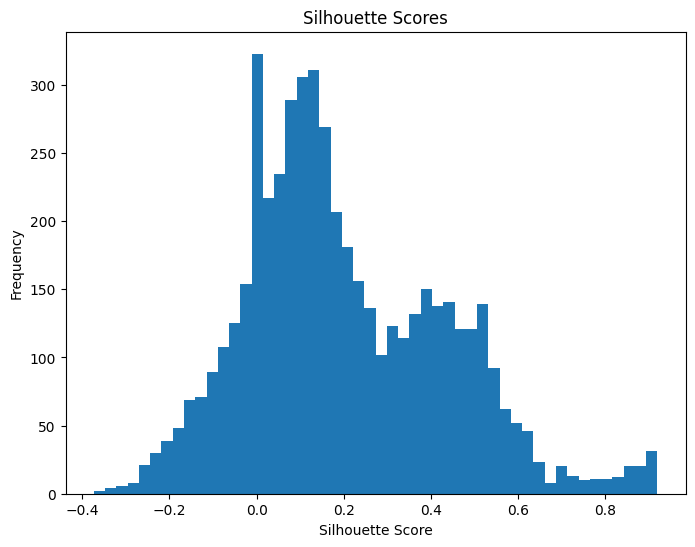

In [ ]:
import matplotlib.pyplot as plt
from sklearn.metrics import silhouette_samples, silhouette_score
from sklearn.manifold import TSNE
import numpy as np
from sklearn.cluster import KMeans

silhouette_avg = silhouette_score(test_features, cluster_labels)
sample_silhouette_values = silhouette_samples(test_features, cluster_labels)

plt.figure(figsize=(8, 6))
plt.hist(sample_silhouette_values, bins=50)
plt.title('Silhouette Scores')
plt.xlabel('Silhouette Score')
plt.ylabel('Frequency')
plt.show()

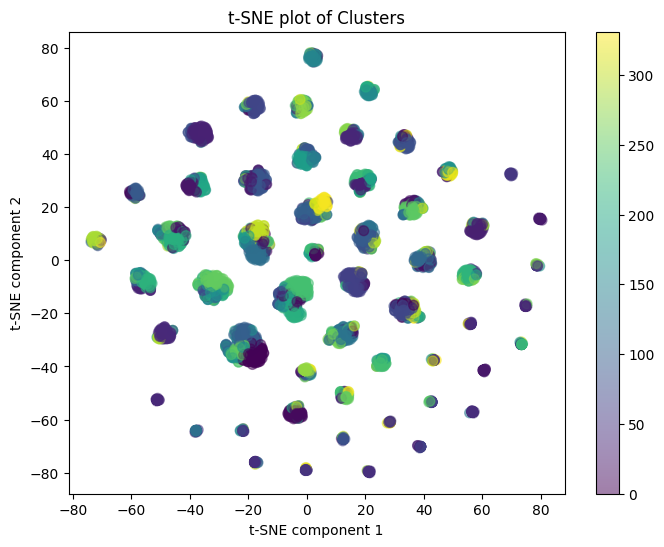

In [ ]:
tsne = TSNE(n_components=2, random_state=42)
test_features_2d = tsne.fit_transform(test_features)

plt.figure(figsize=(8, 6))
plt.scatter(test_features_2d[:, 0], test_features_2d[:, 1], c=cluster_labels, cmap='viridis', s=50, alpha=0.5)
plt.colorbar()
plt.title('t-SNE plot of Clusters')
plt.xlabel('t-SNE component 1')
plt.ylabel('t-SNE component 2')
plt.show()